# Regression and Other Stories: Congress

Predictive uncertainty for congressional elections. See Chapters 10 and 15 in Regression and Other Stories.

--------

In [1]:
using DataFrames, StatsPlots, CSV, HTTP
using Distributions, Turing, MCMCChains
using Random

In [2]:
data = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Congress/data/congress.csv"
congress = CSV.File(HTTP.get(data).body) |> DataFrame
first(congress, 6)

,inc86,inc88,inc90,v86,v88,v90,v86_adj,v88_adj,v90_adj
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,1,0.745036,0.772443,0.714029,0.745036,0.772443,0.714029
2,1,1,1,0.673845,0.636182,0.59705,0.673845,0.636182,0.59705
3,1,1,0,0.696457,0.664928,0.521043,0.696457,0.664928,0.521043
4,-1,-1,-1,0.46459,0.273834,0.234377,0.46459,0.273834,0.234377
5,-1,-1,0,0.391095,0.263613,0.477439,0.391095,0.263613,0.477439
6,-1,-1,-1,0.358245,0.334193,0.256297,0.358245,0.334193,0.256297


In [3]:
data88 = congress[:,[:v88_adj, :v86_adj, :inc88]]
rename!(data88, Dict(
    "v88_adj"=>"vote",
    "v86_adj"=>"past_vote",
    "inc88"=>"inc"
));

In [4]:
@model function m88(past_vote, inc, vote)
    
    # sd
    σ ~ truncated(Normal(0,1), 0, Inf)
    
    # Linear
    α ~ Normal(0, 1) 
    β_v ~ Normal(0, 1) 
    β_i ~ Normal(0, 1) 
    
    μ = α .+ β_v * past_vote .+ β_i * inc  
    vote ~ MvNormal(μ, σ)
end;

In [5]:
model88 = m88(data88.past_vote, data88.inc, data88.vote)
chain88 = sample(model88, NUTS(0.50), 4000)
summarystats(chain88)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    0.2395    0.0166     0.0003    0.0005   1055.2750    1.0001    ⋯
         β_i    0.0971    0.0066     0.0001    0.0002   1145.8257    1.0006    ⋯
         β_v    0.5180    0.0316     0.0005    0.0010   1027.4785    1.0001    ⋯
           σ    0.0673    0.0023     0.0000    0.0000   2008.3072    1.0000    ⋯
                                                                1 column omitted


## Simulation for inferences and predictions of new data points

### Predict from 1988 to 1990

In [6]:
data90 = congress[:,[:v88_adj, :inc90]]
rename!(data90, Dict(
    "v88_adj"=>"past_vote",
    "inc90"=>"inc"
));

### Simulate predictive simulations of the vector of new outcomes

In [7]:
mpred90 = m88(data90.past_vote, data90.inc, missing);
p90=predict(mpred90, chain88);

### Simulate the number of elections predicted to be won by the Democrats in 1990

In [8]:
pred90 = get(p90,[:vote]);

In [9]:
# pred90 is a nested data structure that's not easy to access
# try creating a matrix instead
preds_mat = hcat([c.data[:] for c in pred90.vote]...)
dems_pred = sum(preds_mat,dims=2);

In [10]:
println(
    mean(dems_pred) |> x->round(x,digits=1), " ",
    std(dems_pred) |> x->round(x,digits=1)
)

235.3 2.0


 note - these values are a little different than the original nb, should look into this (priors?)

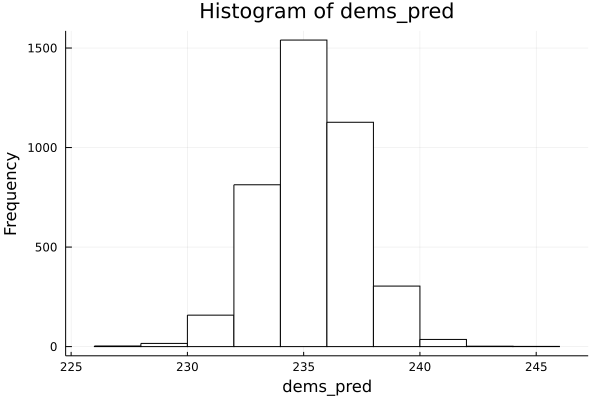

In [11]:
histogram(
    dems_pred,
    title="Histogram of dems_pred",
    xlabel="dems_pred",
    ylabel="Frequency",
    bins=10,
    legend=false,
    color=:white
)

## Graphs

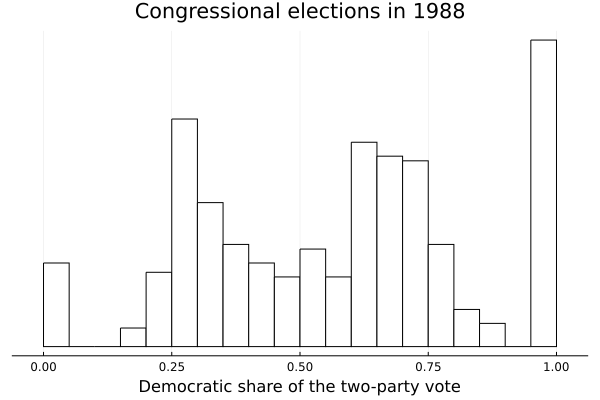

In [12]:
v88_hist = copy(congress.v88)
v88_hist = ifelse.(v88_hist .>0.9, 0.9999, v88_hist)
v88_hist = ifelse.(v88_hist .<0.1, 0.0001, v88_hist)

histogram(
    v88_hist,
    bins=0:0.05:1,
    legend=false,
    color=:white,
    yaxis=false,
    yticks=false,
    title="Congressional elections in 1988",
    xlabel="Democratic share of the two-party vote"
)

In [13]:
# Hand-roll runif function using Random and special jitter function in original

function runif(lower,upper)
    return( rand() * (upper-lower) + lower )
end
    
function jitt(vote)
    # Add jitter to corners of plot
    #n = length(vote)
    return( 
        ifelse.(
            vote .< 0.1,            # if lower corner 
            runif.(0.01, 0.04),     # make some random value [0.01, 0.04]
            ifelse.(
                vote .> 0.9,        # if upper corner
                runif.(0.96,0.99),   # make some random value [0.96, 0.99]
                vote                # Otherwise give true value
            )             
        )
    )
end

j_v86 = jitt(congress.v86);
j_v88 = jitt(congress.v88);

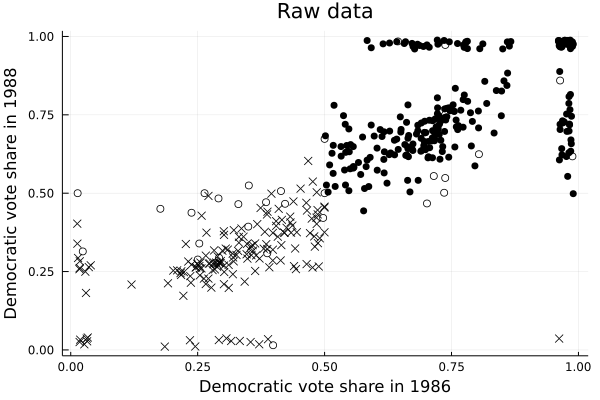

In [14]:
scatter(
    j_v86[congress.inc88 .== 0], 
    j_v88[congress.inc88 .== 0],
    legend=false,
    color=:white,
    marker=:circle,
    xlabel="Democratic vote share in 1986",
    ylabel="Democratic vote share in 1988",
    title="Raw data"
)

scatter!(
    j_v86[congress.inc88 .== 1], 
    j_v88[congress.inc88 .== 1],
    color=:black,
)
scatter!(
    j_v86[congress.inc88 .== -1], 
    j_v88[congress.inc88 .== -1],
    marker=:x,
    color=:black,
)

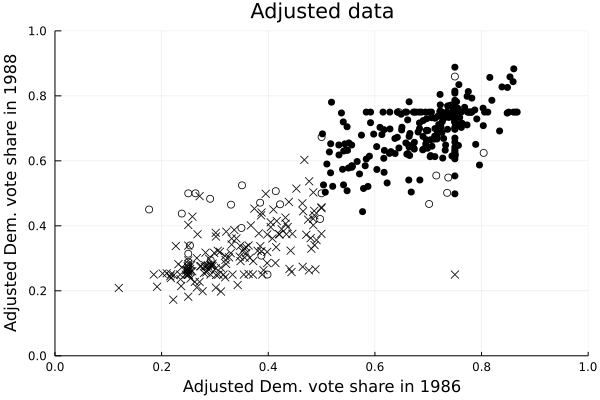

In [15]:
scatter(
    congress.v86_adj[congress.inc88 .== 0], 
    congress.v88_adj[congress.inc88 .== 0],
    legend=false,
    color=:white,
    marker=:circle,
    xlabel="Adjusted Dem. vote share in 1986",
    ylabel="Adjusted Dem. vote share in 1988",
    title="Adjusted data",
    xlim=(0,1.0), ylim=(0,1.0)
)

scatter!(
    congress.v86_adj[congress.inc88 .== 1], 
    congress.v88_adj[congress.inc88 .== 1],
    color=:black,
)
scatter!(
    congress.v86_adj[congress.inc88 .== -1], 
    congress.v88_adj[congress.inc88 .== -1],
    marker=:x,
    color=:black,
)